Copyright (C) Jędrzej Kubica, Nicolas Thierry-Mieg, 2024-2025

This file was written by Jędrzej Kubica and Nicolas Thierry-Mieg
(CNRS, France) Nicolas.Thierry-Mieg@univ-grenoble-alpes.fr

This program is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY;
without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program.
If not, see <https://www.gnu.org/licenses/>.

## This is a notebook for the validation of GBA centrality

Contents:

- **Part 1: Tissue-enrichment validation**

    Part 1.1. We compare the ratio of predicted causal genes enriched in the tissue with the ratio of all genes enriched in the tissue. We compare the two ratios using Fisher's exact test to answer the question: "Are predicted causal genes significantly enriched in the tissue of interest?".

    Part 1.2. We compare ratios of predicted causal genes enriched in the tissue for GBA centrality and Random Walk with Restart (RWR).

    Part 1.3. We compare directly tissue enrichment of GBA centrality vs RWR.

- **Part 2: Leave-one-out validation: GBA centrality vs RWR**

    This is a comparison between empirical CDF (cumulative distribution function) for ranks of left-out genes from GBA centrality and RWR. We compare the ranks of left-out genes using the Wilcoxon signed-rank test.

- **Additionally: Runtime comparison of GBA centrality and betweenness centrality**

In [1]:
import os
import sys

import scipy
import numpy

import random

import matplotlib.pyplot

sys.path.append(os.path.join(os.path.abspath(''), '..'))
import data_parser

In [2]:
def parse_scores(scores_file):
    '''
    Loads the scores generated with GBA_centrality.py
    Returns:
    - ENSG2score: dict with key=ENSG, value=score
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2score = {}
    gene2ENSG = {}
    ENSG2gene = {}
 
    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            split_line = line.rstrip().split('\t')
            ENSG, gene, score = split_line

            ENSG2score[ENSG] = float(score)
            gene2ENSG[gene] = ENSG
            ENSG2gene[ENSG] = gene

    return ENSG2score, gene2ENSG, ENSG2gene

In [3]:
def parse_RWR_scores(scores_file):
    '''
    Loads the scores generated with MultiXrank
    Returns:
    - ENSG2score: dict with key=ENSG, value=score
    '''
    ENSG2score = {}
 
    with open(scores_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            split_line = line.rstrip().split('\t')
            _, ENSG, score = split_line

            ENSG2score[ENSG] = float(score)

    return ENSG2score

In [4]:
def parse_expression_data(expression_data, interactome):
    '''
    Loads a TSV file with columns: ENSG\tgene_expression_ratio
    Returns a dictionary: key=ENSG, value=gene_expression_ratio
    '''
    tissue_expression = {}

    with open(expression_data) as f:
        # skip header
        for _ in range(4):
            next(f)
        header = next(f)
        if not header.startswith("Gene ID"):
            raise Exception("Expression data file wrong header")
        
        for line in f:
            split_line = line.rstrip().split('\t', maxsplit=2)
            ENSG, tissue_ratio, _ = split_line

            if ENSG in interactome:
                tissue_expression[ENSG] = float(tissue_ratio)
    
    return tissue_expression

In [5]:
def take_top_percent(list, x):
    '''
    Finds the top x% of values in a list
    Returns: 
    - top: list with top x% of values
    - rest: list with the rest of values
    '''
    num_elements = round(len(list) * x/100)
    # num_elements = max(num_elements)

    top = list[:num_elements]
    rest = list[num_elements:]
    
    return top, rest

In [6]:
def intersection(list_1, list_2):
    '''
    Returns a list with common elements for two lists
    '''
    return list(set(list_1) & set(list_2))

In [7]:
def format_pvalue(pvalue):
    '''Returns the p-value in the notation: "1.00e-2**" '''
    p = '{:.2e}'.format(pvalue)

    if pvalue <= 0.0001:
        return "p < 10^-4****"
    elif pvalue <= 0.001:
        return "p < 10^-3***"
    elif pvalue <= 0.01:
        return "p < 0.01**"
    elif pvalue <= 0.05:
        return "p < 0.05*"    
    return f"p = {p}"

### Set parameters and paths

In [34]:
'''Set parameters with which GBA_centrality.py was run'''
PHENOTYPE = "MMAF" # to choose from: MMAF, NOA, DILCARD, HYPCARD, BC (breast cancer), CC (colon cancer)
ALPHA = 0.5
alpha = str(ALPHA).replace('.', '')
D_MAX = 10

In [35]:
INTERACTOME_FILE = "../Interactome/interactome_human.sif"

RESULTS_FILE = f"../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores.tsv"
LEAVE_ONE_OUT_FILE = f"../output/{PHENOTYPE}/alpha{alpha}_d{D_MAX}/scores_leave_one_out.tsv"

RESULTS_RWR_FILE = f"/home/kubicaj/workspace/MultiXrank/{PHENOTYPE}/output_{PHENOTYPE}/multiplex_1.tsv"

In [36]:
'''Data and parameters for Part II: Tissue-enrichment validation'''
PRED_CAUSAL_DEF = 10 # [%]
TISSUE_ENRICHED_DEF = 10 # [%]

TISSUE = "testis" # to choose from: testis, breast, colon, heart

GTEX_DATA_FILE = f"/home/kubicaj/workspace/data/input_GBA/E-MTAB-5214-query-results-{TISSUE}-ratio.tpms.tsv"

In [37]:
'''Set path for output figures'''
FIGURES_DIR = "../figures/"

### Load data

In [38]:
'''Parse interactome'''
interactome = data_parser.parse_interactome(interactome_file=INTERACTOME_FILE)
print(f"Interactome: {len(interactome.nodes())} proteins, {len(interactome.edges())} interactions")

Interactome: 15928 proteins, 160283 interactions


In [39]:
'''Load GBA centrality scores and leave-one-out results, then sort them by descending scores'''
ENSG2score_all, gene2ENSG, ENSG2gene = parse_scores(RESULTS_FILE)
ENSG2score_leaveOneOut, _, _ = parse_scores(LEAVE_ONE_OUT_FILE)

ENSG2score = ENSG2score_all.copy()

# remove seed proteins from scores
for gene in ENSG2score_leaveOneOut:
    del ENSG2score[gene]

results_sorted = sorted(ENSG2score.keys(), key=lambda item: ENSG2score[item], reverse=True)
scores_sorted = [ENSG2score[node] for node in results_sorted]

results_leave_one_out_sorted = sorted(ENSG2score_leaveOneOut.keys(),
                                      key=lambda item: ENSG2score_leaveOneOut[item],
                                      reverse=True)
scores_leave_one_out_sorted = [ENSG2score_leaveOneOut[node] for node in results_leave_one_out_sorted]

### Part 1: Tissue-enrichment validation

Part 1.1. Tissue-enrichment validation: GBA centrality

In [40]:
'''Load tissue expression (see README)'''
tissue_expr = parse_expression_data(GTEX_DATA_FILE, interactome=interactome)

In [41]:
'''Get top x% of highest-scoring genes (including causal)'''

# due to obsolete GTEx data, ...
for gene in interactome:
    if gene not in tissue_expr:
        del ENSG2score_all[gene]

results_all_sorted = sorted(ENSG2score_all.keys(), key=lambda item: ENSG2score_all[item], reverse=True)
pred_causal, non_pred_causal = take_top_percent(results_all_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal)} higest-scoring genes")

Selected 1569 higest-scoring genes


In [42]:
'''Get top x% of genes enriched in the tissue'''
tissue_expr_sorted = sorted(tissue_expr.keys(), key=lambda item: tissue_expr[item], reverse=True)
tissue_enriched, non_tissue_enriched = take_top_percent(tissue_expr_sorted, TISSUE_ENRICHED_DEF)

print(f"Selected {len(tissue_enriched)} {TISSUE}-enriched genes")

Selected 1569 testis-enriched genes


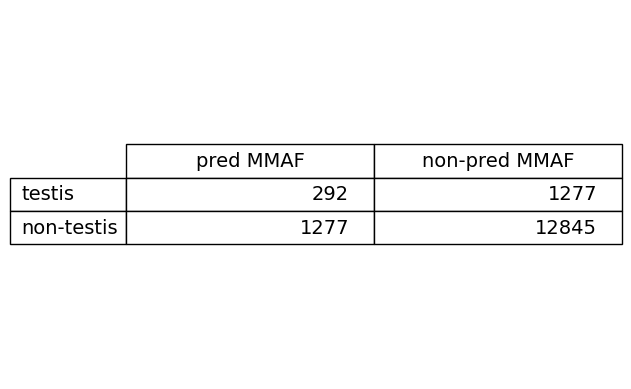

In [43]:
'''Construct a contingency matrix for the Fisher exact test'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(non_pred_causal, tissue_enriched))
x3 = len(intersection(pred_causal, non_tissue_enriched))
x4 = len(intersection(non_pred_causal, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [44]:
''' 
Check if the ratio of predicted causal proteins enriched in the tissue is greater 
than the ratio of all proteins enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 10^-4****


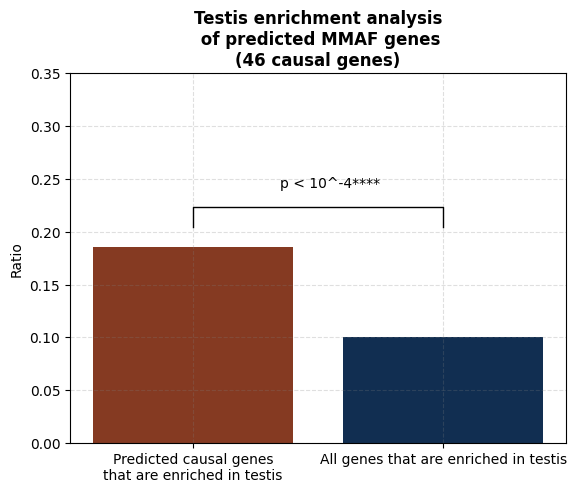

In [45]:
proportion1 = x1 / (x1 + x3) # ratio of predicted causal genes that are tissue-enriched
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4) # ratio of all genes that are tissue-enriched

labels = [f"Predicted causal genes\nthat are enriched in {TISSUE}", 
          f"All genes that are enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])
matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\n of predicted {PHENOTYPE} genes\n({len(ENSG2score_leaveOneOut)} causal genes)", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

# matplotlib.pyplot.savefig(FIGURES_DIR + f"{PHENOTYPE}_tissue_enrichment", dpi=1000)

#### Part 1.2. Tissue-enrichment validation: RWR

In [46]:
'''Load MultiXrank scores and leave-one-out results, then sort them by descending scores'''
ENSG2score_RWR = parse_RWR_scores(RESULTS_RWR_FILE)

In [47]:
'''Get top x% of highest-scoring genes (including causal)'''

# due to obsolete GTEx data, ...
for gene in interactome:
    if gene not in tissue_expr:
        del ENSG2score_RWR[gene]

results_RWR_sorted = sorted(ENSG2score_RWR.keys(), key=lambda item: ENSG2score_RWR[item], reverse=True)
pred_causal_RWR, non_pred_causal_RWR = take_top_percent(results_RWR_sorted, PRED_CAUSAL_DEF)

print(f"Selected {len(pred_causal)} higest-scoring genes")

Selected 1569 higest-scoring genes


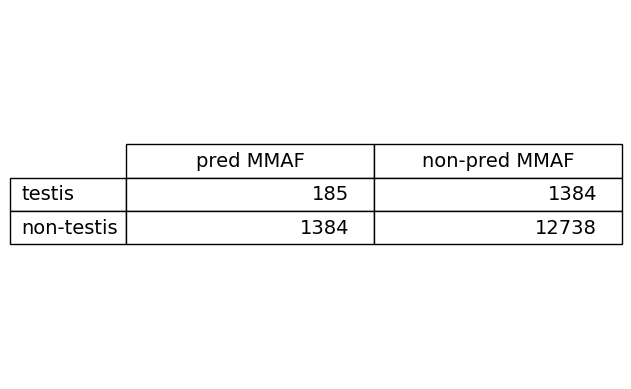

In [48]:
'''Construct a contingency matrix for the Fisher exact test'''
x1 = len(intersection(pred_causal_RWR, tissue_enriched))
x2 = len(intersection(non_pred_causal_RWR, tissue_enriched))
x3 = len(intersection(pred_causal_RWR, non_tissue_enriched))
x4 = len(intersection(non_pred_causal_RWR, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 colLabels=[f'pred {PHENOTYPE}', f'non-pred {PHENOTYPE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [49]:
''' 
Check if the ratio of predicted causal genes enriched in the tissue is greater 
than the ratio of all genes enriched in the tissue

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 0.01**


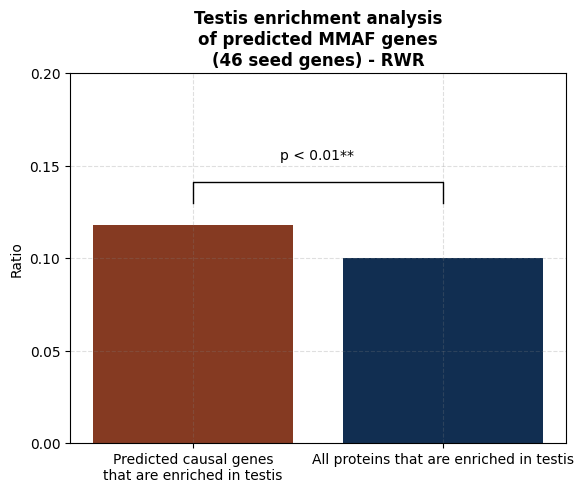

In [50]:
proportion1 = x1 / (x1 + x3) # ratio of predicted causal genes that are tissue-enriched
proportion2 = (x1 + x2) / (x1 + x2 + x3 + x4) # ratio of all genes that are tissue-enriched

labels = [f"Predicted causal genes\nthat are enriched in {TISSUE}", 
          f"All proteins that are enriched in {TISSUE}"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#853A22', '#112E51'])
matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted {PHENOTYPE} genes\n({len(ENSG2score_leaveOneOut)} seed genes) - RWR", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)

# matplotlib.pyplot.savefig(FIGURES_DIR + f"RWR_{PHENOTYPE}_tissue_enrichment", dpi=1000)

#### Part 1.3. Tissue-enrichment validation: GBA centrality vs RWR

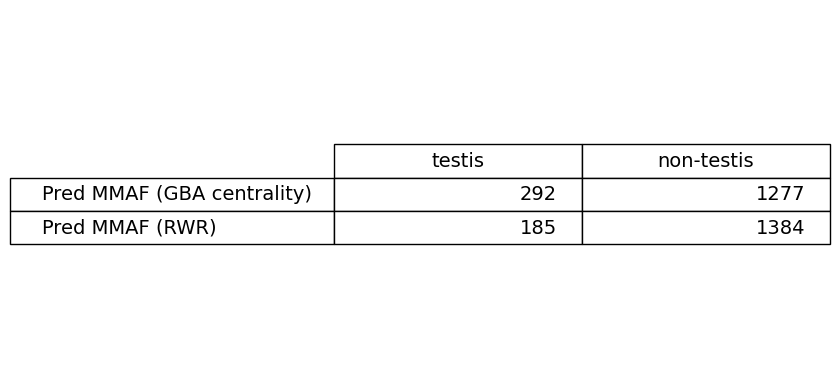

In [51]:
'''Construct a contingency matrix for the Fisher exact test to compare GBA centrality and RWR'''
x1 = len(intersection(pred_causal, tissue_enriched))
x2 = len(intersection(pred_causal, non_tissue_enriched))
x3 = len(intersection(pred_causal_RWR, tissue_enriched))
x4 = len(intersection(pred_causal_RWR, non_tissue_enriched))

contingency_matrix = [[x1, x2], [x3, x4]]

# plot the contingency table
fig, ax = matplotlib.pyplot.subplots()
table = ax.table(contingency_matrix, 
                 rowLabels=[f'Pred {PHENOTYPE} (GBA centrality)', f'Pred {PHENOTYPE} (RWR)'], 
                 colLabels=[f'{TISSUE}', f'non-{TISSUE}'], 
                 loc="center")
ax.axis('tight')
ax.axis('off')
table.set_fontsize(14)
table.scale(1,2)

In [52]:
''' 
Check if the ratio of predicted causal genes enriched in the tissue is greater
for GBA centrality than for RWR

Note: alternative='greater' is the probability that a random table has x >= a, 
where contingency_matrix = [[a, b], [c, d]]
'''
_, p_tissue_expr = scipy.stats.fisher_exact(contingency_matrix, alternative='greater')

p_tissue_expr = format_pvalue(pvalue=p_tissue_expr)
print(f"{p_tissue_expr}")

p < 10^-4****


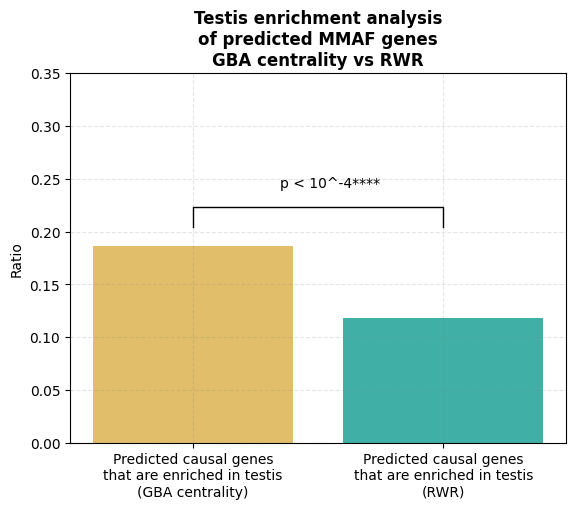

In [53]:
proportion1 = x1 / (x1 + x2) # ratio of predicted causal genes that are tissue-enriched (GBA centrality)
proportion2 = x3 / (x3 + x4) # ratio of predicted causal genes that are tissue-enriched (RWR)

labels = [f"Predicted causal genes\nthat are enriched in {TISSUE}\n(GBA centrality)", 
          f"Predicted causal genes\nthat are enriched in {TISSUE}\n(RWR)"]

matplotlib.pyplot.bar(x=labels, height=[proportion1, proportion2], color=['#E1BE6A', '#40B0A6'])
matplotlib.pyplot.title(f"{TISSUE.capitalize()} enrichment analysis\nof predicted {PHENOTYPE} genes\nGBA centrality vs RWR", weight='bold', fontsize=12)

# plot p-value
h = .1 * max(proportion1, proportion2)
y = max(proportion1, proportion2) + h

matplotlib.pyplot.plot([labels[0], labels[0], labels[1], labels[1]], [y, y+h, y+h, y], lw=1, c='black')
matplotlib.pyplot.text(x=0.35,y=y+2*h, s=f"{p_tissue_expr}")

y_max = 2*max(proportion1, proportion2)
matplotlib.pyplot.yticks(numpy.arange(0, y_max, 0.05))
matplotlib.pyplot.ylabel("Ratio")

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

# matplotlib.pyplot.savefig(FIGURES_DIR + f"GBA_vs_RWR_{PHENOTYPE}_tissue_enrichment", dpi=1000)

### Part 2: Leave-one-out validation: GBA centrality vs RWR

In [54]:
def parse_RWR_ranks(ranks_file):
    '''
    Loads the ranks generated with MultiXrank
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    '''
    ENSG2rank = {}
 
    with open(ranks_file, 'r') as f:
        data = f.read().splitlines()
        for line in data:
            split_line = line.rstrip().split('\t')
            ENSG, rank = split_line

            ENSG2rank[ENSG] = int(rank)

    return ENSG2rank

In [55]:
def parse_GBA_ranks(ranks_file):
    '''
    Loads the scores generated with GBA_centrality_PR.py
    Returns:
    - ENSG2rank: dict with key=ENSG, value=rank
    - gene2ENSG: dict with key=gene, value=ENSG
    - ENSG2gene: dict key=ENSG, value=gene
    '''
    ENSG2rank = {}
    gene2ENSG = {}
    ENSG2gene = {}
 
    with open(ranks_file, 'r') as f:
        # skip header
        next(f)

        data = f.read().splitlines()
        for line in data:
            split_line = line.rstrip().split('\t')
            ENSG, gene, rank = split_line

            ENSG2rank[ENSG] = int(rank)
            gene2ENSG[gene] = ENSG
            ENSG2gene[ENSG] = gene

    return ENSG2rank, gene2ENSG, ENSG2gene

In [56]:
ENSG2rank_RWR = parse_RWR_ranks(F"/home/kubicaj/workspace/MultiXrank/{PHENOTYPE}/RWR_ranks_leave_one_out.tsv")
ENSG2rank_GBA, _, _ = parse_GBA_ranks(F"/home/kubicaj/workspace/Interactome-TIMC/output/{PHENOTYPE}/alpha05_d10/ranks_leave_one_out.tsv")

In [57]:
len(interactome)

15928

In [58]:
ranks_RWR = []
ranks_GBA = []

for gene in ENSG2rank_RWR:
    ranks_RWR.append(ENSG2rank_RWR[gene])
    ranks_GBA.append(ENSG2rank_GBA[gene])

In [67]:
ranks_random = []

for gene in ENSG2rank_RWR:
    l = []
    for i in range(1000):
        tmp = random.randint(1, len(interactome))
        l.append(tmp)

    rank = sum(l) / len(l)
    ranks_random.append(rank)

In [68]:
curve_RWR = []
curve_GBA = []
curve_random = []

for i in range(len(interactome)):
    curve_RWR.append(sum(rank <= i for rank in ranks_RWR))
    curve_GBA.append(sum(rank <= i for rank in ranks_GBA))
    curve_random.append(sum(rank <= i for rank in ranks_random))

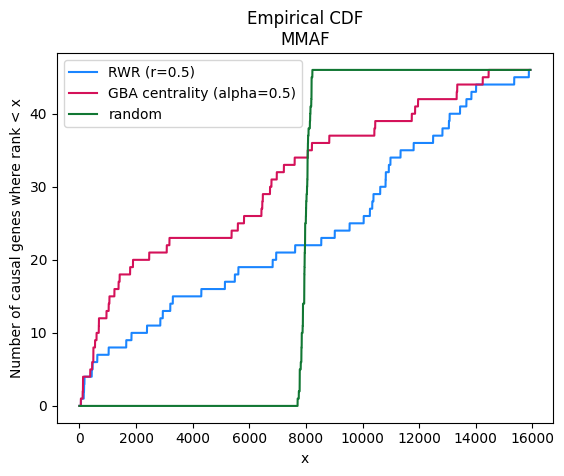

In [69]:
matplotlib.pyplot.plot(range(len(interactome)), curve_RWR, label="RWR (r=0.5)", color="#1A85FF")
matplotlib.pyplot.plot(range(len(interactome)), curve_GBA, label="GBA centrality (alpha=0.5)", color="#D41159")
matplotlib.pyplot.plot(range(len(interactome)), curve_random, label="random", color="#117733")
matplotlib.pyplot.title(f"Empirical CDF\n{PHENOTYPE}")
matplotlib.pyplot.xlabel("x")
matplotlib.pyplot.ylabel("Number of causal genes where rank < x")
matplotlib.pyplot.legend()

In [70]:
scipy.stats.wilcoxon(ranks_random, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=np.float64(890.0), pvalue=np.float64(3.332382559051439e-05))

In [71]:
scipy.stats.wilcoxon(ranks_RWR, ranks_GBA, alternative="greater")

WilcoxonResult(statistic=np.float64(897.0), pvalue=np.float64(2.2615251054958208e-05))

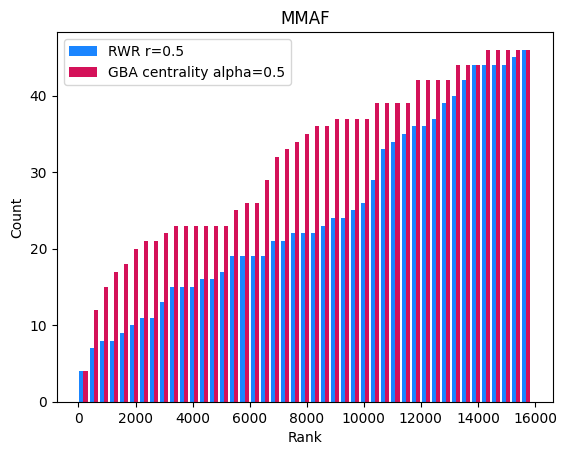

In [72]:
xs = numpy.linspace(0, max(ranks_RWR), len(ranks_RWR))
matplotlib.pyplot.hist([ranks_RWR, ranks_GBA], xs, label=["RWR r=0.5", "GBA centrality alpha=0.5"], cumulative=True, color=["#1A85FF", "#D41159"])
matplotlib.pyplot.title(f"{PHENOTYPE}")
matplotlib.pyplot.xlabel("Rank")
matplotlib.pyplot.ylabel("Count")
matplotlib.pyplot.legend()

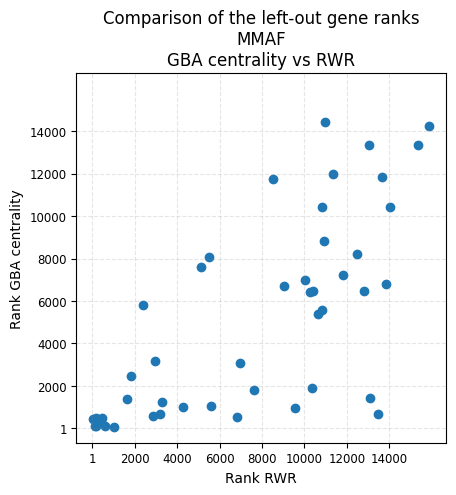

In [64]:
matplotlib.pyplot.scatter(x=ranks_RWR, y=ranks_GBA)
matplotlib.pyplot.title(f"Comparison of the left-out gene ranks\n{PHENOTYPE}\nGBA centrality vs RWR")
matplotlib.pyplot.xlabel("Rank RWR")
matplotlib.pyplot.ylabel("Rank GBA centrality")

ticks  = numpy.arange(0, len(interactome), step=2000)
ticks[0] = 1
ticks = ticks[::-1]

matplotlib.pyplot.xticks(ticks, fontsize=8.5)
matplotlib.pyplot.yticks(ticks, fontsize=8.5)

matplotlib.pyplot.axis('square')

matplotlib.pyplot.grid(True, linestyle='--', which='major',
                   color='grey', alpha=0.2)

### Runtime comparison of GBA centrality and betweenness centrality

In [58]:
%%capture
# networkx.betweenness_centrality(interactome) # 11 min 17 sec for our interactome